# Data 612 Project 2 Content-Based and Collaborative Filtering
## Erick Hadi

Building simple movie recommender system using:
- Content-Based Filtering
- User-User Collaborative Filtering
- Item-Item Collaborative Filtering

We'll evaluate each method using RMSE on sampled MovieLens data.


## Import Libraries

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

## Load and Prepare Data

In [134]:
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [135]:
movies['genres'] = movies['genres'].fillna("").apply(lambda x: " ".join(x.split('|')))

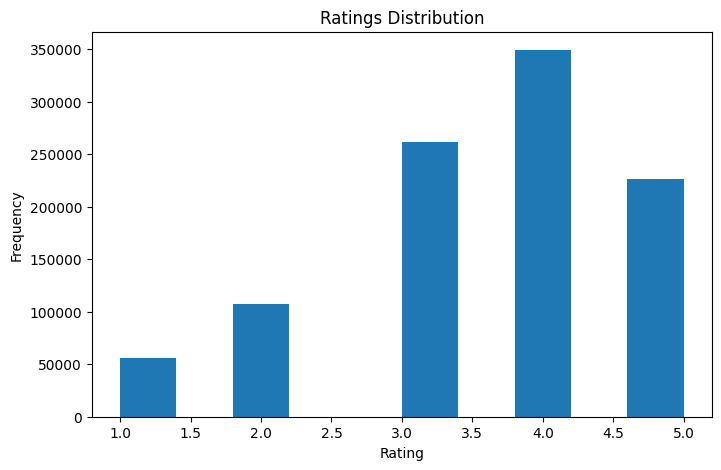

In [136]:
def plot_ratings_distribution():
    plt.figure(figsize=(8, 5))
    ratings['rating'].hist(bins=10)
    plt.title('Ratings Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()

plot_ratings_distribution()

## Content-Based Filtering

In [137]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['title'])

In [138]:
def genre_recommendations(title, top_n=10):
    idx = indices[title]
    sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [139]:
genre_recommendations('Toy Story (1995)')

,title
1050,Aladdin and the King of Thieves (1996)
2072,"American Tail, An (1986)"
2073,"American Tail: Fievel Goes West, An (1991)"
2285,"Rugrats Movie, The (1998)"
2286,"Bug's Life, A (1998)"
3045,Toy Story 2 (1999)
3542,Saludos Amigos (1943)
3682,Chicken Run (2000)
3685,"Adventures of Rocky and Bullwinkle, The (2000)"
236,"Goofy Movie, A (1995)"


## Collaborative Filtering

In [140]:
small_data = ratings.sample(frac=0.02, random_state=42)
train_data, test_data = train_test_split(small_data, test_size=0.2, random_state=42)

user_item_matrix = small_data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

user_similarity = 1 - pairwise_distances(user_item_matrix, metric='cosine')
np.fill_diagonal(user_similarity, 0)

item_similarity = 1 - pairwise_distances(user_item_matrix.T, metric='cosine')
np.fill_diagonal(item_similarity, 0)


In [141]:
def predict_ratings(ratings_matrix, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings_matrix.mean(axis=1).values.reshape(-1, 1)
        ratings_diff = ratings_matrix.values - mean_user_rating
        pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings_matrix.values.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [142]:
def rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [143]:
train_matrix = user_item_matrix.values
user_pred = predict_ratings(user_item_matrix, user_similarity, type='user')
item_pred = predict_ratings(user_item_matrix, item_similarity, type='item')

<ipython-input-141-1156135249>:5: RuntimeWarning: invalid value encountered in divide
  pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
<ipython-input-141-1156135249>:7: RuntimeWarning: invalid value encountered in divide
  pred = ratings_matrix.values.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])


In [144]:
user_pred = np.nan_to_num(user_pred)
item_pred = np.nan_to_num(item_pred)

print("User-Based CF RMSE:", rmse(user_pred, train_matrix))
print("Item-Based CF RMSE:", rmse(item_pred, train_matrix))

User-Based CF RMSE: 2.9776070454569346
Item-Based CF RMSE: 3.3883378319551745


## Conclusion

- **User-based Collaborative Filtering** performs better on this dataset with RMSE = 2.98.
- **Item-based CF** is slightly worse, possibly due to data sparsity.
- **Content-based recommendations** work well for giving similar genre-based suggestions.